# Socket Programming

In [1]:
import socket

## Basic socket API

The most used methods

In [2]:
# create a new socket using the given address family, 
# socket type and protocol number
socket.socket?

Init signature: socket.socket(family=-1, type=-1, proto=-1, fileno=None)
Docstring:      A subclass of _socket.socket adding the makefile() method.
File:           /Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/socket.py
Type:           type
Subclasses:     SSLSocket


Address Family Constants - a type of addresses that your socket can communicate with:  
`socket.AF_UNIX` - Unix sockets  
`socket.AF_INET` - IPv4  
`socket.AF_INET6` - IPv6  
When you create a socket, you have to specify its address family, and then you can only use addresses of that type with the socket.

Socket Type Constants  
`SOCK_STREAM` - used for TCP  
`SOCK_DGRAM` - used for UDP  

In [3]:
s = socket.socket()

In [4]:
s.bind?

Docstring:
bind(address)

Bind the socket to a local address.  For IP sockets, the address is a
pair (host, port); the host must refer to the local host. For raw packet
sockets the address is a tuple (ifname, proto [,pkttype [,hatype [,addr]]])
Type:      builtin_function_or_method


In [5]:
s.listen?

Docstring:
listen([backlog])

Enable a server to accept connections.  If backlog is specified, it must be
at least 0 (if it is lower, it is set to 0); it specifies the number of
unaccepted connections that the system will allow before refusing new
connections. If not specified, a default reasonable value is chosen.
Type:      builtin_function_or_method


In [6]:
s.accept?

Signature: s.accept()
Docstring:
accept() -> (socket object, address info)

Wait for an incoming connection.  Return a new socket
representing the connection, and the address of the client.
For IP sockets, the address info is a pair (hostaddr, port).
File:      /Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/socket.py
Type:      method


In [7]:
s.connect?

Docstring:
connect(address)

Connect the socket to a remote address.  For IP sockets, the address
is a pair (host, port).
Type:      builtin_function_or_method


In [8]:
s.connect_ex?

Docstring:
connect_ex(address) -> errno

This is like connect(address), but returns an error code (the errno value)
instead of raising an exception when an error occurs.
Type:      builtin_function_or_method


In [9]:
s.send?

Docstring:
send(data[, flags]) -> count

Send a data string to the socket.  For the optional flags
argument, see the Unix manual.  Return the number of bytes
sent; this may be less than len(data) if the network is busy.
Type:      builtin_function_or_method


In [10]:
s.recv?

Docstring:
recv(buffersize[, flags]) -> data

Receive up to buffersize bytes from the socket.  For the optional flags
argument, see the Unix manual.  When no data is available, block until
at least one byte is available or until the remote end is closed.  When
the remote end is closed and all data is read, return the empty string.
Type:      builtin_function_or_method


In [11]:
s.close?

Signature: s.close()
Docstring:
close()

Close the socket.  It cannot be used after this call.
File:      /Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/socket.py
Type:      method


### The sequence of socket API calls and data flow for TCP

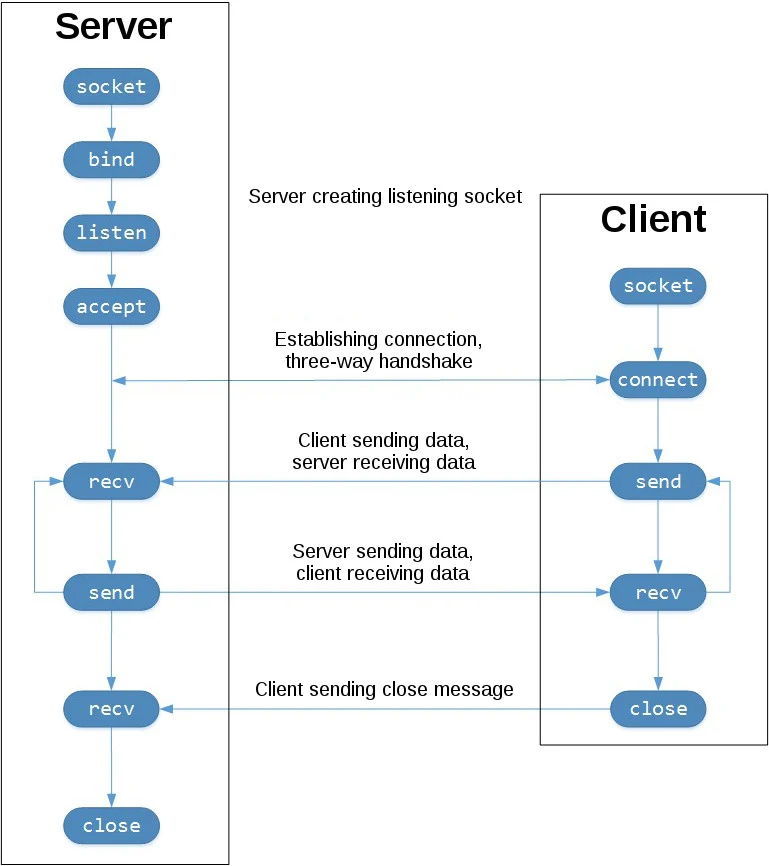

In [12]:
from IPython.display import Image
Image("images/sockets-tcp-flow.png")

## Echo Server

In [ ]:
# %load echo-server.py
import socket

HOST = "127.0.0.1" # Standard loopback interface address (localhost)
PORT = 65432 # # Port to listen on (non-privileged ports are > 1023)

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
# associate the socket with specific network interface and port number
    s.bind((HOST, PORT))
    s.listen()
    conn, addr = s.accept() # CREATES A NEW SOCKET
    with conn:
        print(f'Connected by {addr}')
        while True:
            data = conn.recv(1024)
            if not data:
                break
            conn.sendall(data)

The .accept() method blocks execution and waits for an incoming connection. When a client connects, it returns a new socket object representing the connection and a tuple holding the address of the client. The tuple will contain (host, port) for IPv4 connections or (host, port, flowinfo, scopeid) for IPv6. 

`socket.accept()`
1. The socket must be bound to and address and listening for connections.  
2. `socket.accept()` returns `(conn, address)` where `conn` is a **new socket object** usable to send and receive data on the connection. It's distinct from the listening socket that the server is using to accept new connections.

### Blocking calls

In a socket module, methods:  
    * `.accept()`  
    * `.connect()`  
    * `.send()`  
    * `.recv()`  
block, meaning they don't return immediately.
Blocking calls have to wait on system calls (I/O) to complete before they can return a value.
Blocking socket calls can be set to non-blocking mode so they return immediately.

If `conn.recv()` returns an empty `bytes` object, b'', 
that signals that the client closed the connection and the loop is terminated.

## Echo Client

In [ ]:
# %load echo-client.py
import socket

HOST = "127.0.0.1"  # The server's hostname or IP address
PORT = 65432  # The port used by the server

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((HOST, PORT)) # connect to server
    s.sendall(b"Hello world") # send message
    data = s.recv(1024) # read the server's reply
    
print(f"Received {data!r}")

### Check state of the socket

In [ ]:
# netstat
netstat -an | grep 65432

In [ ]:
Proto Recv-Q Send-Q  Local Address       Foreign Address (state)
tcp4       0      0  127.0.0.1.65432     *.*             LISTEN

In [ ]:
# lsof
lsof -i -n

In [ ]:
COMMAND     PID   USER   FD   TYPE   DEVICE SIZE/OFF      NODE  NAME
Python     8776 marcin   3u   IPv4 0x3a28f5f604a00157      0t0  TCP 127.0.0.1:65432 (LISTEN)

## Communication Breakdown

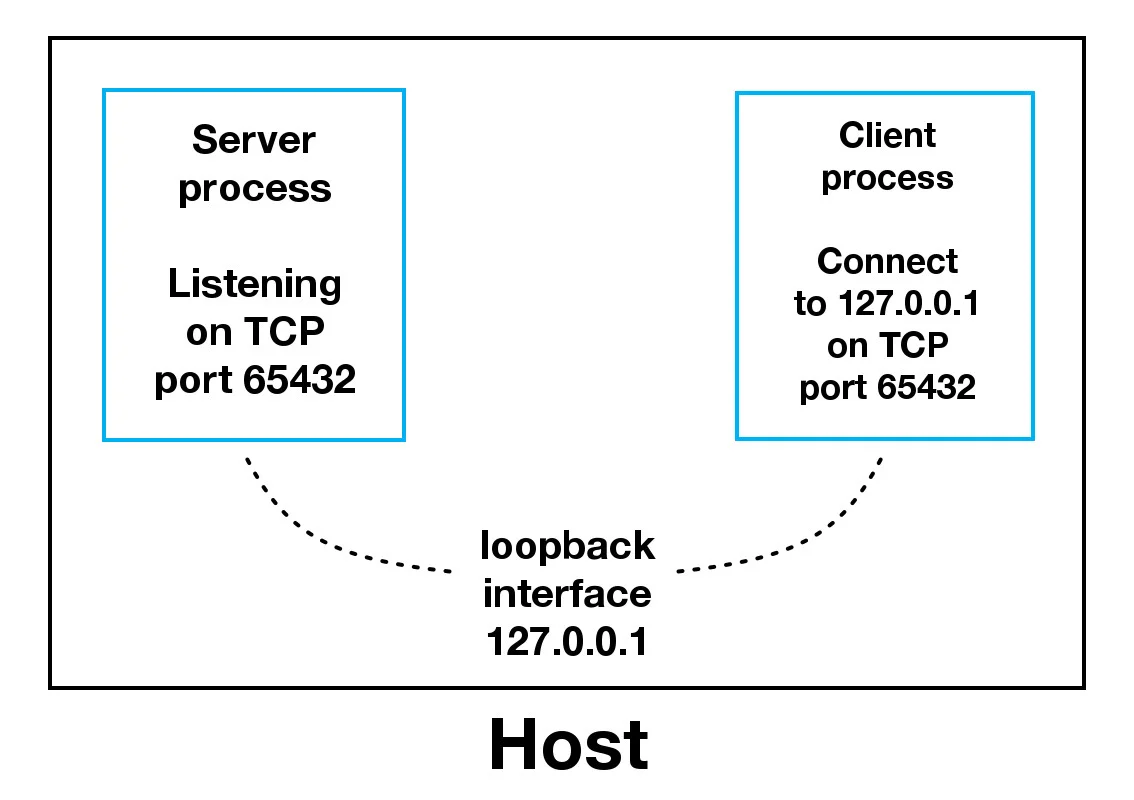

In [13]:
Image("images/sockets-loopback-interface.png")

Applications use the loopback interface to communicate with other processes running on the host and for security and isolation fro the external network.

## Handling Multiple Connections

Sending data:
* `send()` - send data, but no guaranttee that all of the bytes will be transmitted  
* `sendall()` - unlike `send()` contniues to send data from bytes until either all data has been sent or an error occurs.

### Multi-Connection Server

In [ ]:
# %load multiconn-server.py
import sys
import socket
import selectors
import types

sel = selectors.DefaultSelector()

host, port = sys.argv[1], int(sys.argv[2])
lsock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
lsock.bind((host, port))
lsock.listen()
print(f'Listening on {(host, port)}')

# configure non-blocking mode
lsock.setblocking(False)
# sel.register() registers the socket to be monitored with sel.select() 
# For the listening socket, you want read events: selectors.EVENT_READ. 
sel.register(lscok, selectors.EVENT_READ, data=None)


def accept_wrapper(sock):
    conn, addr = sock.accept() # should be ready to read
    print(f'Accepted connection from {addr}')
    conn.setblocking(False)
    data = types.SimpleNamespace(addr=addr, inb=b"", outb=b"")
    events = selectors.EVENT_READ | selectors.EVENT_WRITE
    sel.register(conn, events, data=data)
    
def service_connection(key, mask):
    sock = key.fileobj
    data = key.data
    # True if socket ready for reading
    if mask &selectors.EVENT_READ:
        recv_data = sock.recv(1024)
        if recv_data:
            data.outb += recv_data
        else:
            print(f'Closing connection to {data.addr}')
            sel.unregister(sock)
            sock.close()
    if mask & selectors.EVENT_WRITE:
        if data.outb:
            print(f'Echoing {data.outb!r} to {data.addr}')
            sent = sock.send(data.outb)
            # discard sent data from the buffer
            data.outb = data.outb[sent:]

try:
    while True:
        # blocks until sockets are ready for I/O
        # sel.select() returns a list of tuples, one for each socket.
        events = sel.select(timeout=None)
        # key - SelectorKey namedtuple; key.fileobj is the socket object
        # mask - event mask of the operations that are ready
        for key, mask in events:
            # if None then from listening socket
            if key.data is None:
                accept_wrapper(key.fileobj)
            # client socket that's already been accepted; you want to service it
            else:
                service_connection(key, mask)
            

In [ ]:
# %load multiconn-client.py
import sys
import socket
import selectors
import types

sel = selectors.DefaultSelector()
messages = [b"Message 1 from client.", b"Message 2 from client."]

def start_connections(host, port, num_conns):
    server_addr = (host, port)
    for i in range(num_conns):
        connid = i + 1
        print(f'Starting connection {connid} to {server_addr}')
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.setblocking(False)
        # connect() would raise BlockingIOError
        sock.connect_ex(server_addr)
        events = selectors.EVENT_READ | selectors.EVENT_WRITE
        data = types.SimpleNamespace(
            connid=connid,
            msg_total=sum(len(m) for m in messages),
            recv_total=0,
            messages=messages.copy(),
            outb=b"",
        )
        sel.register(sock, events, data=data)
        
def service_connection(key, mask):
    sock = keyfileobj
    data = key.data
    if mask & selectors.EVENT_READ:
        recv_data = osck.recv(1024)
        if recv_data:
            print(f'Received {recv_data!r} from connection {data.connid}')
            data.recv_total += len(recv_data)
        if not recv_data or data.recv_total == data.msg_total:
            print(f'Closing connection {data.connid}')
            sel.unregister(sock)
            sock.close()
    if mask & selectors.EVENT_WRITE:
        if not data.outb and data.messages:
            data.outb = data.messages.pop(0)
        if data.outb:
            print(f'Sending {data.outb!r} to connection {data.connid}')
            sent = sock.send(data.outb)
            data.outb = data.outb[sent:]

# Work in progress...